In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import os
from google.colab import drive
from tensorflow.keras.utils import to_categorical

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths to the dataset
train_dir = '/content/drive/My Drive/dataset/splitdataset48x48/train'
val_dir = '/content/drive/My Drive/dataset/splitdataset48x48/val'

In [ ]:
# Define parameters
batch_size = 256  # Adjust for faster training
input_shape = (48, 48, 1)  # Image dimensions with single channel (grayscale)
num_classes = 26  # Assuming 26 classes (A-Z + Blank)


In [ ]:
# Helper function to load and preprocess images
def process_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Grayscale images
    image = tf.image.resize(image, [48, 48])  # Resize to target size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    label = tf.one_hot(label, num_classes)  # One-hot encode the label
    return image, label

In [ ]:
# Helper function to load dataset
def load_dataset(directory):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, file_name))
            labels.append(label)
    return image_paths, labels, class_names


In [ ]:
# Load training and validation datasets
train_image_paths, train_labels, class_names = load_dataset(train_dir)
val_image_paths, val_labels, _ = load_dataset(val_dir)


In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))


In [ ]:
# Apply preprocessing
train_dataset = train_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Shuffle, batch, and prefetch for performance
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Initialize the model
model = Sequential()

# Add an Input layer
model.add(Input(shape=(48, 48, 1)))

# Add layers to the model
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with the correct number of classes
model.add(Dense(num_classes, activation='softmax'))


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Print the model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,498 (3.21 MB)

 Trainable params: 841,498 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define TensorBoard callback
log_dir = "logs/fit/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=90,  # Set the number of epochs
    validation_data=val_dataset,
    callbacks=[tensorboard_callback]  # Use TensorBoard to monitor performance
)

Epoch 1/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 353s 20s/step - accuracy: 0.0492 - loss: 3.3024 - val_accuracy: 0.0595 - val_loss: 3.2566
Epoch 2/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.0572 - loss: 3.2576 - val_accuracy: 0.0783 - val_loss: 3.2470
Epoch 3/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.0665 - loss: 3.2470 - val_accuracy: 0.3528 - val_loss: 3.2233
Epoch 4/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2111 - loss: 3.1831 - val_accuracy: 0.3466 - val_loss: 3.0357
Epoch 5/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2162 - loss: 2.9561 - val_accuracy: 0.4582 - val_loss: 2.5088
Epoch 6/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.3152 - loss: 2.4590 - val_accuracy: 0.6086 - val_loss: 1.7460
Epoch 7/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4840 - loss: 1.8484 - val_accuracy: 0.7756 - val_loss: 1.0246
Epoch 8/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6162 - loss: 1.3261 - val_accuracy: 0.8486 - val_los

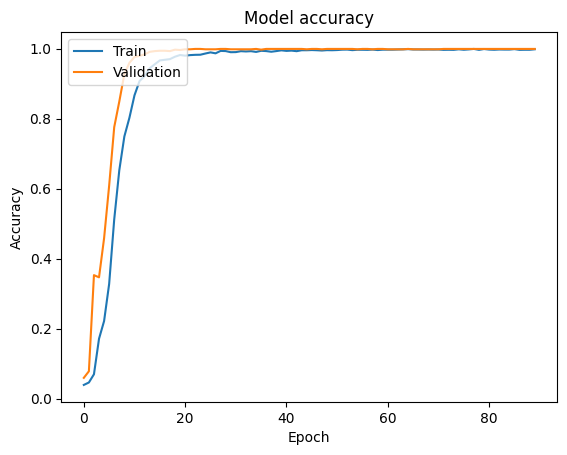

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


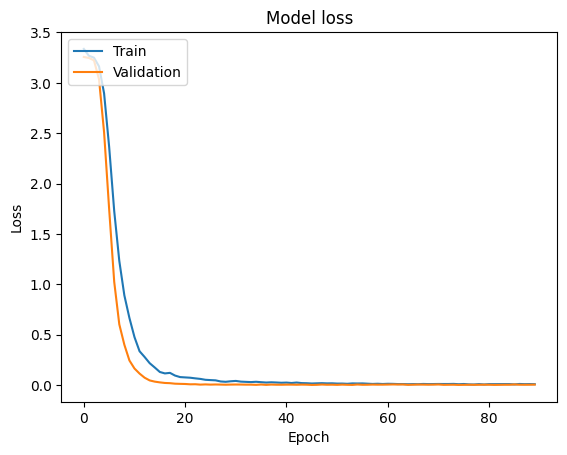

In [ ]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model architecture to JSON
model_json = model.to_json()
json_file_path = "/content/drive/MyDrive/signlanguagedetectionmodel48x48.json"
with open(json_file_path, 'w') as json_file:
    json_file.write(model_json)

# Save model weights
h5_file_path = "/content/drive/MyDrive/signlanguagedetectionmodel48x48.h5"
model.save(h5_file_path)

print("Model architecture and weights have been saved successfully.")


Model architecture and weights have been saved successfully.


In [ ]:
model.save('my_model.keras')
